In [1]:
import pandas as pd
import xarray as xr
import numpy as np

## compute seasonal means of salinity using hycom raw data

In [3]:
df_fechas_temporadas = pd.read_csv("/home/jupyter-daniela/suyana/peru_production/outputs/calas_temporadas_fechas_inicio_fin.csv", index_col=0)
df_fechas_temporadas.drop(index=['temporada', np.nan], inplace=True)
df_fechas_temporadas['anio'] = pd.to_datetime(df_fechas_temporadas['fecha_inicio']).dt.year

df_fechas_temporadas

,fecha_inicio,fecha_fin,anio
2da 2015,2015-11-17,2016-01-22,2015
1ra 2016,2016-06-18,2016-07-26,2016
2da 2016,2016-11-11,2017-01-26,2016
1ra 2017,2017-04-22,2017-07-31,2017
2da 2017,2017-11-23,2018-01-25,2017
1ra 2018,2018-04-07,2018-06-26,2018
2da 2018,2018-11-15,2019-01-14,2018
1ra 2019,2019-04-28,2019-07-30,2019
2da 2019,2019-11-06,2020-01-02,2019
1ra 2020,2020-05-13,2020-07-24,2020


In [5]:
meses

[4, 5, 6]

In [23]:
from pathlib import Path


path_hycom_data = Path("/home/jupyter-daniela/suyana/sources/hycom/")

for _, row in df_fechas_temporadas.iterrows():
    t0 = pd.to_datetime(row["fecha_inicio"])
    t1 = pd.to_datetime(row["fecha_fin"])
    meses = pd.period_range(t0.to_period("M"), t1.to_period("M"), freq="M")

    datasets = []
    for m in meses:
        f = path_hycom_data / str(m.year) / f"hycom_{m.year}{m.month:02d}.nc"
        if not f.exists():
            continue
        ds = xr.open_dataset(f)
        ds = ds.sel(depth=0)
        ds = ds.sortby("time")
        ds = ds.sel(time=slice(t0, t1))
        if ds.sizes.get("time", 0) > 0:
            datasets.append(ds)

    if not datasets:
        continue

    lat_shapes = [ds.sizes["lat"] for ds in datasets]
    lon_shapes = [ds.sizes["lon"] for ds in datasets]

    if len(set(lat_shapes)) > 1 or len(set(lon_shapes)) > 1:
        ds_ref = max(datasets, key=lambda d: (d.sizes["lat"] * d.sizes["lon"]))
        target_lat = ds_ref["lat"]
        target_lon = ds_ref["lon"]
        datasets_interp = []
        for ds in datasets:
            if not (
                ds.sizes["lat"] == ds_ref.sizes["lat"]
                and ds.sizes["lon"] == ds_ref.sizes["lon"]
            ):
                ds = ds.interp(lat=target_lat, lon=target_lon)
            datasets_interp.append(ds)
        datasets = datasets_interp

    ds_concat = xr.concat(datasets, dim="time", join="override")
    ds_mean = ds_concat.mean(dim="time", skipna=True)
    print(row.name, ds_mean.sizes)

        # ds_mean.to_netcdf(f"hycom_mean_{row.name}_{ianio}.nc")









2da 2015 Frozen({'lat': 251, 'lon': 251})
1ra 2016 Frozen({'lat': 251, 'lon': 251})
2da 2016 Frozen({'lat': 251, 'lon': 251})
1ra 2017 Frozen({'lat': 251, 'lon': 251})
2da 2017 Frozen({'lat': 251, 'lon': 251})
1ra 2018 Frozen({'lat': 251, 'lon': 251})
2da 2018 Frozen({'lat': 501, 'lon': 251})
1ra 2019 Frozen({'lat': 501, 'lon': 251})
2da 2019 Frozen({'lat': 501, 'lon': 251})
1ra 2020 Frozen({'lat': 501, 'lon': 251})
2da 2020 Frozen({'lat': 501, 'lon': 251})
1ra 2021 Frozen({'lat': 501, 'lon': 251})
2da 2021 Frozen({'lat': 501, 'lon': 251})
1ra 2022 Frozen({'lat': 501, 'lon': 251})
2da 2022 Frozen({'lat': 501, 'lon': 251})
1ra 2023 Frozen({'lat': 501, 'lon': 251})
2da 2023 Frozen({'lat': 501, 'lon': 251})
1ra 2024 Frozen({'lat': 501, 'lon': 251})


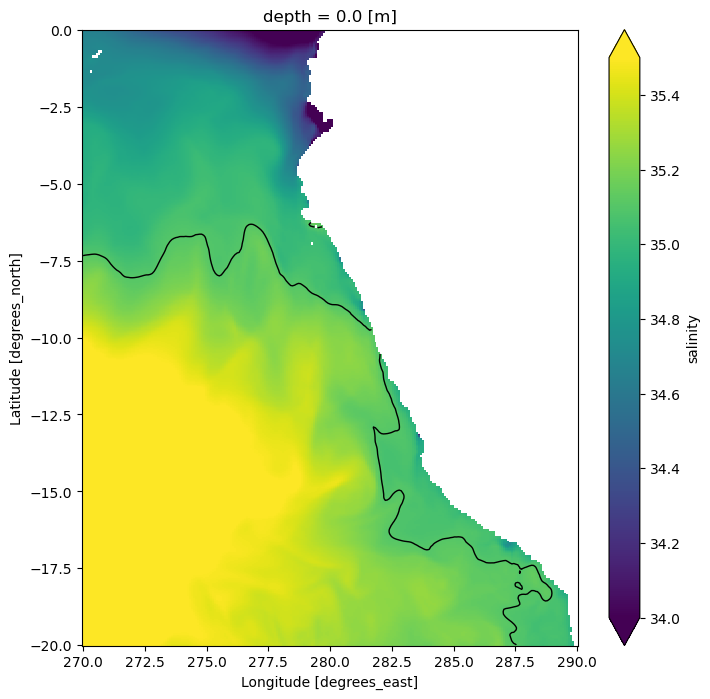

In [39]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ds_concat['salinity'].mean('time').plot(vmin=34, vmax=35.5, ax=ax)

import matplotlib.pyplot as plt

ax.contour(
    ds_concat['lon'], ds_concat['lat'],
    ds_concat['salinity'].mean('time'),
    levels=[35.1], colors='black', linewidths=1
)
plt.show()
